# Train locally
_**Train a model locally: Directly on your machine and within a Docker container**_

In [1]:
#Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples`
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.18.0


## Initialize Workspace <a id='init'></a>

Initialize your workspace object from configuration file

In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

mm-aml-dev
mm-machine-learning-dev-rg
eastus2
5da07161-3770-4a4b-aa43-418cbbb627cf


## Create An Experiment <a id='exp'></a>
An experiment is a logical container in an Azure ML Workspace. It contains a series of trials called `Runs`. As such, it hosts run records such as run metrics, logs, and other output artifacts from your experiments.

In [5]:
from azureml.core import Experiment
experiment_name = 'train-on-local-alliant'
exp = Experiment(workspace=ws, name=experiment_name)

## 5. View training and auxiliary scripts <a id='view'></a>

View the files: (`train.py`) script and supportive libraries (`mylib.py`)

In [6]:
with open('./train.py', 'r') as f:
    print(f.read())

# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
import os
import numpy as np
import mylib
# sklearn.externals.joblib is removed in 0.23
try:
    from sklearn.externals import joblib
except ImportError:
    import joblib

os.makedirs('./outputs', exist_ok=True)

X, y = load_diabetes(return_X_y=True)

run = Run.get_context()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)
data = {"train": {"X": X_train, "y": y_train},
        "test": {"X": X_test, "y": y_test}}

# list of numbers from 0.0 to 1.0 with a 0.05 interval
alphas = mylib.get_alphas()

for alpha in alphas:
    # Use Ridge algorithm to creat

In [7]:
with open('./mylib.py', 'r') as f:
    print(f.read())

# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

import numpy as np


def get_alphas():
    # list of numbers from 0.0 to 1.0 with a 0.05 interval
    return np.arange(0.0, 1.0, 0.05)



In [8]:
from sklearn.datasets import load_diabetes
import pandas as pd
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Create dataframe using iris.data
df = pd.DataFrame(data=diabetes.data)
df.rename(columns = {0:'AGE', 1: "SEX", 2:"BMI", 3: "BP" ,4:"S1" , 5:"S2",6:"S3" , 7: "S4", 8: "S5", 9: "S6"}, inplace = True) 
 
# Append class / label data
df["y"] = diabetes.target
 
# Print the data and check for yourself
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [22]:
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

## Configure & Run <a id='config-run'></a>
### A User-managed environment

#### 6.A.a Set the environment up
When using a user-managed environment, you are responsible for ensuring that all the necessary packages are available in the Python environment you choose to run the script in.

In [9]:
from azureml.core import Environment

# Editing a run configuration property on-fly.
user_managed_env = Environment("user-managed-env")

user_managed_env.python.user_managed_dependencies = True

# You can choose a specific Python environment by pointing to a Python path 
#user_managed_env.python.interpreter_path = '/home/johndoe/miniconda3/envs/myenv/bin/python'

#### Submit the script to run in the user-managed environment
Whatever the way you manage your environment, you need to use the `ScriptRunConfig` class. It allows you to further configure your run by pointing to the `train.py` script and to the working directory, which also contains the `mylib.py` file. These inputs indeed provide the commands to execute in the run. Once the run is configured, you submit it to your experiment.

In [10]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory='./', script='train.py', environment=user_managed_env)

In [11]:
run = exp.submit(src)

#### 6.A.c Get run history details

While all calculations were run on your machine (cf. below), by using a `run` you also captured the results of your calculations into your run and experiment. You can then see them on the Azure portal, through the link displayed as output of the following cell.

**Note**: The recording of the computation results into your run was made possible by the `run.log()` commands in the `train.py` file.

In [12]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local-alliant,train-on-local-alliant_1606862711_c901725a,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


Note: if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

Block any execution to wait until the run finishes.

In [13]:
run.wait_for_completion(show_output=True)

RunId: train-on-local-alliant_1606862711_c901725a
Web View: https://ml.azure.com/experiments/train-on-local-alliant/runs/train-on-local-alliant_1606862711_c901725a?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/mm-machine-learning-dev-rg/workspaces/mm-aml-dev

Execution Summary
RunId: train-on-local-alliant_1606862711_c901725a
Web View: https://ml.azure.com/experiments/train-on-local-alliant/runs/train-on-local-alliant_1606862711_c901725a?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/mm-machine-learning-dev-rg/workspaces/mm-aml-dev



{'runId': 'train-on-local-alliant_1606862711_c901725a',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-12-01T22:45:16.002683Z',
 'endTimeUtc': '2020-12-01T22:45:44.155599Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'fada5d12-482d-441e-9e7c-537c14158bad'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'environment': {'name': 'user-managed-env',
   'version': 'Autosave_2020-12-01T00:52:21Z_c434c9d2',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': True,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2', {'pip': 

**Note:** All these calculations were run on your local machine, in the conda environment you defined above. You can find the results in:
- `~/.azureml/envs/azureml_xxxx` for the conda environment you just created
- `~/AppData/Local/Temp/azureml_runs/train-on-local_xxxx` for the machine learning models you trained (this path may differ depending on the platform you use). This folder also contains
  - Logs (under azureml_logs/)
  - Output pickled files (under outputs/)
  - The configuration files (credentials, local and docker image setups)
  - The train.py and mylib.py scripts
  - The current notebook

Take a few minutes to examine the output of the cell above. It shows the content of some of the log files, and extra information on the conda environment used.

### 6.B System-managed environment
#### 6.B.a Set the environment up
Now, instead of managing the setup of the environment yourself, you can ask the system to build a new conda environment for you. The environment is built once, and will be reused in subsequent executions as long as the conda dependencies remain unchanged.

In [14]:
from azureml.core.conda_dependencies import CondaDependencies

system_managed_env = Environment("system-managed-env")

system_managed_env.python.user_managed_dependencies = False

# Specify conda dependencies with scikit-learn
cd = CondaDependencies.create(conda_packages=['scikit-learn'])
system_managed_env.python.conda_dependencies = cd

#### 6.B.b Submit the script to run in the system-managed environment
A new conda environment is built based on the conda dependencies object. If you are running this for the first time, this might take up to 5 minutes.

The commands used to execute the run are then the same as the ones you used above.

In [15]:
src.run_config.environment = system_managed_env
run = exp.submit(src)

#### 6.B.c Get run history details

In [16]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local-alliant,train-on-local-alliant_1606862864_fe64a9a4,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
run.wait_for_completion(show_output = True)

RunId: train-on-local-alliant_1606862864_fe64a9a4
Web View: https://ml.azure.com/experiments/train-on-local-alliant/runs/train-on-local-alliant_1606862864_fe64a9a4?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/mm-machine-learning-dev-rg/workspaces/mm-aml-dev

Streaming azureml-logs/60_control_log.txt

[2020-12-01T22:47:47.344429] Using urllib.request Python 3.0 or later
Streaming log file azureml-logs/60_control_log.txt
Running: ['cmd.exe', '/c', 'C:\\Users\\memasanz\\AppData\\Local\\Temp\\azureml_runs\\train-on-local-alliant_1606862864_fe64a9a4\\azureml-environment-setup/conda_env_checker.bat']
Starting the daemon thread to refresh tokens in background for process with pid = 6088
Materialized conda environment not found on target: C:\Users\memasanz/.azureml/envs/azureml_4b824bcb98517d791c41923f24d65461


[2020-12-01T22:47:47.590458] Logging experiment preparation status in history service.
Running: ['cmd.exe', '/c', 'C:\\Users\\memasanz\\AppData\\Local\\Temp\

{'runId': 'train-on-local-alliant_1606862864_fe64a9a4',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-12-01T22:52:32.32633Z',
 'endTimeUtc': '2020-12-01T22:52:57.357834Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'fada5d12-482d-441e-9e7c-537c14158bad'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'environment': {'name': 'system-managed-env',
   'version': 'Autosave_2020-12-01T13:54:32Z_68d32138',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2',
      

### 6.C Docker-based execution
In this section, you will train the same models, but you will do so in a Docker container, on your local machine. For this, you then need to have the Docker engine installed locally. If you don't have it yet, please follow the instructions below.

#### How to install Docker

- [Linux](https://docs.docker.com/install/linux/docker-ce/ubuntu/)
- [MacOs](https://docs.docker.com/docker-for-mac/install/)
- [Windows](https://docs.docker.com/docker-for-windows/install/)

    In case of issues, troubleshooting documentation can be found [here](https://docs.docker.com/docker-for-windows/troubleshoot/#running-docker-for-windows-in-nested-virtualization-scenarios). Additionally, you can follow the steps below, if Virtualization is not enabled on your machine:
    - Go to Task Manager > Performance
    - Check that Virtualization is enabled
    - If it is not, go to `Start > Settings > Update and security > Recovery > Advanced Startup - Restart now > Troubleshoot > Advanced options > UEFI firmware settings - restart`
    - In the BIOS, go to `Advanced > System options > Click the "Virtualization Technology (VTx)" only > Save > Exit > Save all changes` -- This will restart the machine

**Notes**: 
- If your kernel is already running in a Docker container, such as **Azure Notebooks**, this mode will **NOT** work.
- If you use a GPU base image, it needs to be used on Microsoft Azure Services such as ACI, AML Compute, Azure VMs, or AKS.

You can also ask the system to pull down a Docker image and execute your scripts in it.

#### 6.C.a Set the environment up

In the cell below, you will configure your run to execute in a Docker container. It will:
- run on a CPU
- contain a conda environment in which the scikit-learn library will be installed.

As before, you will finish configuring your run by pointing to the `train.py` and `mylib.py` files.

In [18]:
docker_env = Environment("docker-env")

docker_env.python.user_managed_dependencies = False
docker_env.docker.enabled = True

# use the default CPU-based Docker image from Azure ML
print(docker_env.docker.base_image)

# Specify conda dependencies with scikit-learn
docker_env.python.conda_dependencies = cd

mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.v1


####  6.C.b Submit the script to run in the system-managed environment

The run is now configured and ready to be executed in a Docker container. If you are running this for the first time, the Docker container will get created, as well as the conda environment inside it. This will take several minutes. Once all this is generated, however, this conda environment will be reused as long as you don't change the conda dependencies.

In [19]:
import subprocess

src.run_config.environment = docker_env

# Check if Docker is installed and Linux containers are enabled
if subprocess.run("docker -v", shell=True).returncode == 0:
    out = subprocess.check_output("docker system info", shell=True).decode('ascii')
    if not "OSType: linux" in out:
        print("Switch Docker engine to use Linux containers.")
    else:
        run = exp.submit(src)
else:
    print("Docker engine is not installed.")

##### Potential issue on Windows and how to solve it

If you are using a Windows machine, the creation of the Docker image may fail, and you may see the following error message
`docker: Error response from daemon: Drive has not been shared. Failed to launch docker container. Check that docker is running and that C:\ on Windows and /tmp elsewhere is shared.`

This is because the process above tries to create a linux-based, i.e. non-windows-based, Docker image. To fix this, you can:
- Open the Docker user interface
- Navigate to Settings > Shared drives
- Select C (or both C and D, if you have one)
- Apply

When this is done, you can try and re-run the command above.

<img src="./docker_settings.png" width="500" align="left">

#### 6.C.c Get run history details

In [20]:
# Get run history details
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local-alliant,train-on-local-alliant_1606863233_68314aa2,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
run.wait_for_completion(show_output=True)

The results obtained here should be the same as those obtained before. However, take a look at the "Execution summary" section in the output of the cell above. Look for "docker". There, you should see the "enabled" field set to True. Compare this to the 2 prior runs ("enabled" was then set to False).

#### 6.C.d Use a custom Docker image

You can also specify a custom Docker image, if you don't want to use the default image provided by Azure ML.
```python
custom_docker_env = Environment("custom-docker-env")
custom_docker_env.docker.enabled = True
```

You can either pull an image directly from Anaconda:
```python
# Use an image available in Docker Hub without authentication
custom_docker_env.docker.base_image = "continuumio/miniconda3"
```

Or one of the images you may already have created:
```python
# or, use an image available in your private Azure Container Registry
custom_docker_env.docker.base_image = "mycustomimage:1.0"
custom_docker_env.docker.base_image_registry.address = "myregistry.azurecr.io"
custom_docker_env.docker.base_image_registry.username = "username"
custom_docker_env.docker.base_image_registry.password = "password"
```

##### Where to find my Docker image name and registry credentials
    If you do not know what the name of your Docker image or container registry is, or if you don't know how to access the username and password needed above, proceed as follows:
    - Docker image name:
        - In the portal, under your resource group, click on your current workspace
        - Click on Experiments
        - Click on Images
        - Click on the image of your choice
        - Copy the "ID" string
        - In this notebook, replace "mycustomimage:1/0" with that ID string
    - Username and password:
        - In the portal, under your resource group, click on the container registry associated with your workspace
            - If you have several and don't know which one you need, click on your workspace, go to Overview and click on the "Registry" name on the upper right of the screen
        - There, go to "Access keys"
        - Copy the username and one of the passwords
        - In this notebook, replace "username" and "password" by these values

In any case, you will need to use the lines above in place of the line marked as `# Reference Docker image` in section 6.C.a. 

When you are using your custom Docker image, you might already have your Python environment properly set up. In that case, you can skip specifying conda dependencies, and just use the `user_managed_dependencies` option instead:
```python
custom_docker_env.python.user_managed_dependencies = True
# path to the Python environment in the custom Docker image
custom_docker_env.python.interpreter_path = '/opt/conda/bin/python'
```

Once you are done defining your environment, set that environment on your run configuration:
```python
src.run_config.environment = custom_docker_env
```

## 7. Query run metrics <a id='query'></a>

Once your run has completed, you can now extract the metrics you captured by using the `get_metrics` method. As shown in the `train.py` file, these metrics are "alpha" and "mse".

In [21]:
# Get all metris logged in the run
run.get_metrics()
metrics = run.get_metrics()

Let's find the model that has the lowest MSE value logged.

In [22]:
import numpy as np

best_alpha = metrics['alpha'][np.argmin(metrics['mse'])]

print('When alpha is {1:0.2f}, we have min MSE {0:0.2f}.'.format(
    min(metrics['mse']), 
    best_alpha
))

When alpha is 0.40, we have min MSE 3295.74.


Let's compare it to the others

Text(0.5,0,'Alpha')

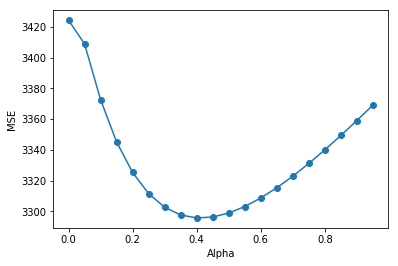

In [23]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.plot(metrics['alpha'], metrics['mse'], marker='o')
plt.ylabel("MSE")
plt.xlabel("Alpha")

You can also list all the files that are associated with this run record

In [24]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/70_driver_log.txt',
 'logs/azureml/8_azureml.log',
 'logs/azureml/dataprep/python_span_1fc3eaad-10a7-4ec9-9e10-f4ea4a5ddc34.jsonl',
 'logs/azureml/dataprep/python_span_24b1663e-1a81-4d1a-a765-e4dda4f9354e.jsonl',
 'logs/azureml/dataprep/python_span_2b4a3448-c515-4559-a1f0-03e16ea982c4.jsonl',
 'logs/azureml/dataprep/python_span_2fb00970-4e20-42af-a86a-f07eaf76b04e.jsonl',
 'logs/azureml/dataprep/python_span_349cb586-9cc7-4fc8-8024-f7885ffd718c.jsonl',
 'logs/azureml/dataprep/python_span_39e8c38c-8180-4d42-be11-85946921941e.jsonl',
 'logs/azureml/dataprep/python_span_3aee2379-d36b-4f95-9c16-4d5e00a595b0.jsonl',
 'logs/azureml/dataprep/python_span_3e6db5b2-db4b-4c71-952a-35aaeffdfd9d.jsonl',
 'logs/azureml/dataprep/python_span_3ef7313e-efac-454b-8b07-4d7e704eab40.jsonl',
 'logs/azureml/dataprep/python_span_40ac1211-638e-45f2-a856-c5fbf2cba99a.jsonl',
 'logs/azureml/dataprep/python_span_4e049ab5-20c2-4d12-93d1-70e8cdea619d.jsonl',
 'logs/

From the results obtained above, `ridge_0.40.pkl` is the best performing model. You can now register that particular model with the workspace. Once you have done so, go back to the portal and click on "Models". You should see it there.

In [25]:
# Supply a model name, and the full path to the serialized model file.
model = run.register_model(model_name='best_ridge_model', model_path='./outputs/ridge_0.40.pkl')

In [26]:
print("Registered model:\n --> Name: {}\n --> Version: {}\n --> URL: {}".format(model.name, model.version, model.url))

Registered model:
 --> Name: best_ridge_model
 --> Version: 2
 --> URL: aml://asset/05623fd202ee4f49835d8003e608548a


You can now deploy your model by following [this example](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/deployment/production-deploy-to-aks/production-deploy-to-aks.ipynb).

In [27]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               auth_enabled=True,
                                               tags={"data": "diabetes",  "method" : "sklearn"}, 
                                               description='ridge')

In [28]:
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

model_name = 'best_ridge_model'
ws = Workspace.from_config()
print('model_name:'+ model_name)

model = Model(ws, model_name)


#myenv = Environment.get(workspace=ws, name="tutorial-env", version=None)
#inference_config = InferenceConfig(source_directory='.', entry_script="score.py", environment=myenv)

model_name:best_ridge_model


In [34]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import Model, InferenceConfig


environment = Environment('my-sklearn-environment')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'scikit-learn',
    'scipy'
])
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

In [35]:
model_name = 'best-ridge-model'

In [36]:
service = Model.deploy(workspace=ws, 
                       name=model_name +'-srv', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig, 
                       overwrite=True)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [39]:
keys = service.get_keys()
selected_key = keys[0]

print(selected_key)
print(service.serialize()['scoringUri'])

Yy4iGRJ4QQvJWY6jLecrTWKmSbRy5vvu
http://86b564df-9a34-4160-9cb2-d7ca9b4ded85.eastus2.azurecontainer.io/score


In [41]:
X, y = load_diabetes(return_X_y=True)
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)
data = {"train": {"X": X_train, "y": y_train},
        "test": {"X": X_test, "y": y_test}}

In [43]:
X_test[0]

array([ 0.01991321,  0.05068012,  0.10480869,  0.07007254, -0.03596778,
       -0.0266789 , -0.02499266, -0.00259226,  0.00371174,  0.04034337])

In [55]:
import requests
import json

endpoint_url = service.serialize()['scoringUri']
headers = {
    "Authorization": "Bearer {}".format(selected_key),
    "Content-Type": "application/json"
}
body = {'data': [
    [.1,.2,.3,.4,.5,.6,.7,.8,.9,.10], 
    [10,9,8,7,6,5,4,3,2,1]
]}
r = requests.post(endpoint_url, headers=headers, data=json.dumps(body))
results = r.json()
results

[571.2589585334908, 3726.995485938575]